In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from plotly.offline import init_notebook_mode,iplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

mutual_funds_df = pd.read_csv(r"/Users/amiralids/Desktop/Morningstar Dataset/Dataset/european-funds-dataset-from-morningstar/Morningstar - European Mutual Funds.csv")
etfs_df = pd.read_csv(r"/Users/amiralids/Desktop/Morningstar Dataset/Dataset/european-funds-dataset-from-morningstar/Morningstar - European ETFs.csv")

In [3]:
!pip install seaborn --upgrade
sns.__version__
# need to install seaborn 0.11 to display a density plot that compares mutual funds and ETFs in the same graph

'0.13.2'

In [126]:
# Load datasets
mf_data = pd.read_csv(r"/Users/amiralids/Desktop/Morningstar Dataset/Dataset/european-funds-dataset-from-morningstar/Morningstar - European Mutual Funds.csv")
etf_data = pd.read_csv(r"/Users/amiralids/Desktop/Morningstar Dataset/Dataset/european-funds-dataset-from-morningstar/Morningstar - European ETFs.csv")

# Display basic information about datasets
print("Mutual Funds Dataset Info:")
print(mf_data.info())
print("\nETFs Dataset Info:")
print(etfs_df.info())

Mutual Funds Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57603 entries, 0 to 57602
Columns: 132 entries, ticker to quarters_down
dtypes: float64(108), int64(2), object(22)
memory usage: 58.0+ MB
None

ETFs Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9495 entries, 0 to 9494
Columns: 132 entries, ticker to quarters_down
dtypes: float64(108), int64(2), object(22)
memory usage: 9.6+ MB
None


In [127]:
# Data Validation: Check for missing and duplicate values in the datasets
print('ETFs Dataset Missing Values:', etfs_df.isnull().sum().sum())
print('Mutual Funds Dataset Missing Values:', mutual_funds_df.isnull().sum().sum())
print('ETFs Dataset Duplicate Rows:', etfs_df.duplicated().sum())
print('Mutual Funds Dataset Duplicate Rows:', mutual_funds_df.duplicated().sum())

ETFs Dataset Missing Values: 443529
Mutual Funds Dataset Missing Values: 2191765
ETFs Dataset Duplicate Rows: 0
Mutual Funds Dataset Duplicate Rows: 0


In [129]:
import numpy as np
from sklearn.impute import KNNImputer

def knn_impute_batches(dataset, batch_size=100, n_neighbors=5):
    """
    Perform KNN imputation in batches to handle large datasets.
    
    Parameters:
    dataset (DataFrame): The dataset with missing values.
    batch_size (int): Size of each batch to process.
    n_neighbors (int): Number of neighbors to use for imputation.
    
    Returns:
    DataFrame: Dataset with missing values imputed.
    """
    numeric_cols = dataset.select_dtypes(include=['float64', 'int64']).columns
    dataset_imputed = dataset.copy()
    
    # Shuffle and split into batches
    shuffled = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    batches = [shuffled.iloc[i:i + batch_size] for i in range(0, len(shuffled), batch_size)]
    imputed_batches = []
    i= 0
    for batch in batches:
        print('batch: ', i)
        i+=1
        batch_imputed = batch.copy()
        imputer = KNNImputer(n_neighbors=n_neighbors)
        
        # Handle columns with all missing values
        all_missing_cols = [col for col in numeric_cols if batch[col].isnull().all()]
        for col in all_missing_cols:
            batch[col] = 0  # Replace with placeholder value
        
        # Perform imputation
        numeric_data = batch[numeric_cols]
        imputed_data = imputer.fit_transform(numeric_data)
        
        # Restore original structure
        imputed_data_df = pd.DataFrame(imputed_data, columns=numeric_cols)
        batch_imputed[numeric_cols] = imputed_data_df[numeric_cols]
        imputed_batches.append(batch_imputed)
    
    return pd.concat(imputed_batches).sort_index()

# Apply batch-wise KNN imputation
batch_imputed_etfs = knn_impute_batches(etf_data, batch_size=100)
batch_imputed_mutual_funds = knn_impute_batches(mf_data, batch_size=100)

batch:  0
batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11
batch:  12
batch:  13
batch:  14
batch:  15
batch:  16
batch:  17
batch:  18
batch:  19
batch:  20
batch:  21
batch:  22
batch:  23
batch:  24
batch:  25
batch:  26
batch:  27
batch:  28
batch:  29
batch:  30
batch:  31
batch:  32
batch:  33
batch:  34
batch:  35
batch:  36
batch:  37
batch:  38
batch:  39
batch:  40
batch:  41
batch:  42
batch:  43
batch:  44
batch:  45
batch:  46
batch:  47
batch:  48
batch:  49
batch:  50
batch:  51
batch:  52
batch:  53
batch:  54
batch:  55
batch:  56
batch:  57
batch:  58
batch:  59
batch:  60
batch:  61
batch:  62
batch:  63
batch:  64
batch:  65
batch:  66
batch:  67
batch:  68
batch:  69
batch:  70
batch:  71
batch:  72
batch:  73
batch:  74
batch:  75
batch:  76
batch:  77
batch:  78
batch:  79
batch:  80
batch:  81
batch:  82
batch:  83
batch:  84
batch:  85
batch:  86
batch:  87
batch:  88
batch:  89
batch:  90
batch:  9

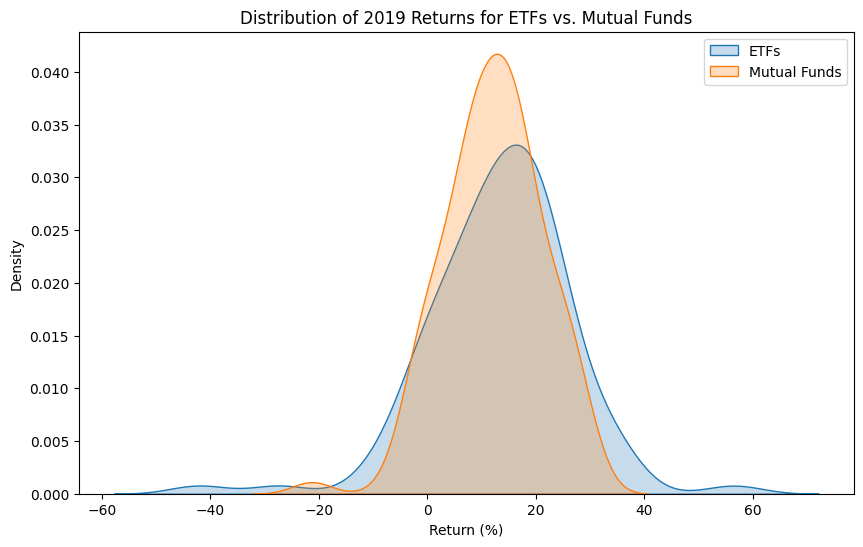

In [133]:
### Exploratory Data Analysis (EDA)
# Visualizing distributions of returns
plt.figure(figsize=(10, 6))
sns.kdeplot(batch_imputed_etfs['fund_return_2019'], label='ETFs', fill=True)
sns.kdeplot(batch_imputed_mutual_funds['fund_return_2019'], label='Mutual Funds', fill=True)
plt.title('Distribution of 2019 Returns for ETFs vs. Mutual Funds')
plt.xlabel('Return (%)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Compare sector exposures
sector_columns = [col for col in etf_data.columns if 'sector_' in col]
sector_means_etfs = batch_imputed_etfs[sector_columns].mean()
sector_means_mutual_funds = batch_imputed_mutual_funds[sector_columns].mean()

# Visualize sector exposures
sector_df = pd.DataFrame({
    'Sector': sector_columns,
    'ETFs': sector_means_etfs.values,
    'Mutual Funds': sector_means_mutual_funds.values
})
sector_df = sector_df.melt(id_vars='Sector', var_name='Type', value_name='Exposure')

px.bar(sector_df, x='Sector', y='Exposure', color='Type', barmode='group',
       title='Sector Exposures: ETFs vs Mutual Funds').show()

In [135]:
### Feature Engineering
# Calculate volatility (standard deviation of historical returns)
historical_returns = [col for col in etf_data.columns if 'fund_return_201' in col]
batch_imputed_etfs['volatility'] = batch_imputed_etfs[historical_returns].std(axis=1)
batch_imputed_mutual_funds['volatility'] = batch_imputed_mutual_funds[historical_returns].std(axis=1)

# Calculate Sharpe Ratio (assuming risk-free rate = 0 for simplicity)
batch_imputed_etfs['sharpe_ratio'] = batch_imputed_etfs['fund_return_2019'] / batch_imputed_etfs['volatility']
batch_imputed_mutual_funds['sharpe_ratio'] = batch_imputed_mutual_funds['fund_return_2019'] / batch_imputed_mutual_funds['volatility']

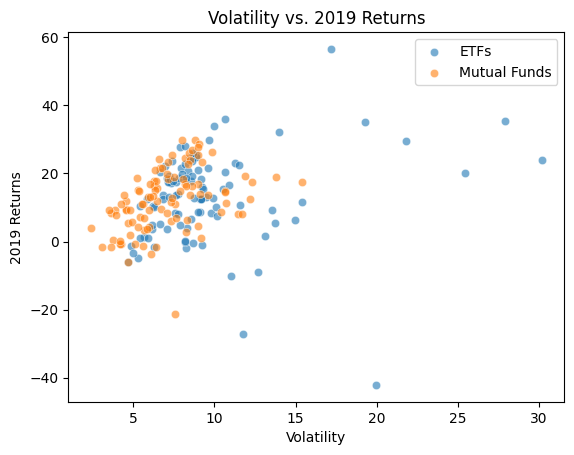

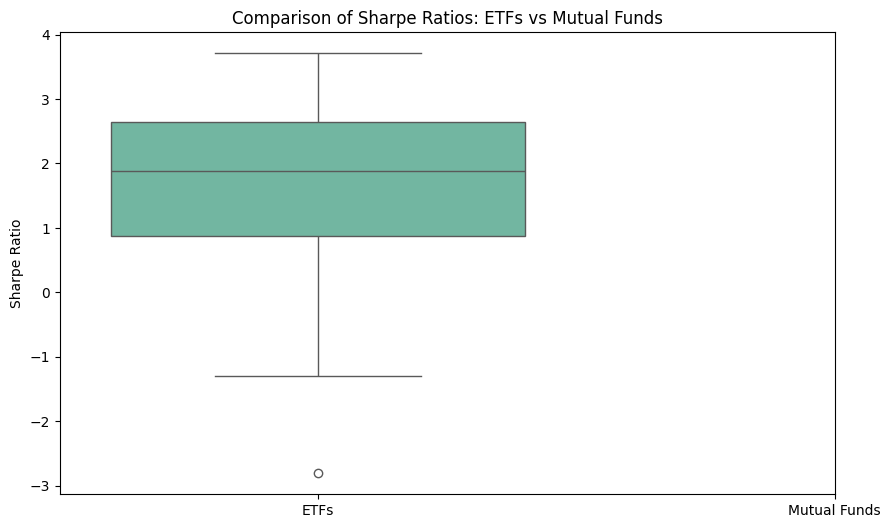

In [136]:
### Comparative Analysis
# Visualize volatility vs returns
sns.scatterplot(x='volatility', y='fund_return_2019', data=batch_imputed_etfs, label='ETFs', alpha=0.6)
sns.scatterplot(x='volatility', y='fund_return_2019', data=batch_imputed_mutual_funds, label='Mutual Funds', alpha=0.6)
plt.title('Volatility vs. 2019 Returns')
plt.xlabel('Volatility')
plt.ylabel('2019 Returns')
plt.legend()
plt.show()

# Compare Sharpe Ratios
plt.figure(figsize=(10, 6))
sns.boxplot(data=[batch_imputed_etfs['sharpe_ratio'], batch_imputed_mutual_funds['sharpe_ratio']], palette='Set2')
plt.xticks([0, 1], ['ETFs', 'Mutual Funds'])
plt.title('Comparison of Sharpe Ratios: ETFs vs Mutual Funds')
plt.ylabel('Sharpe Ratio')
plt.show()

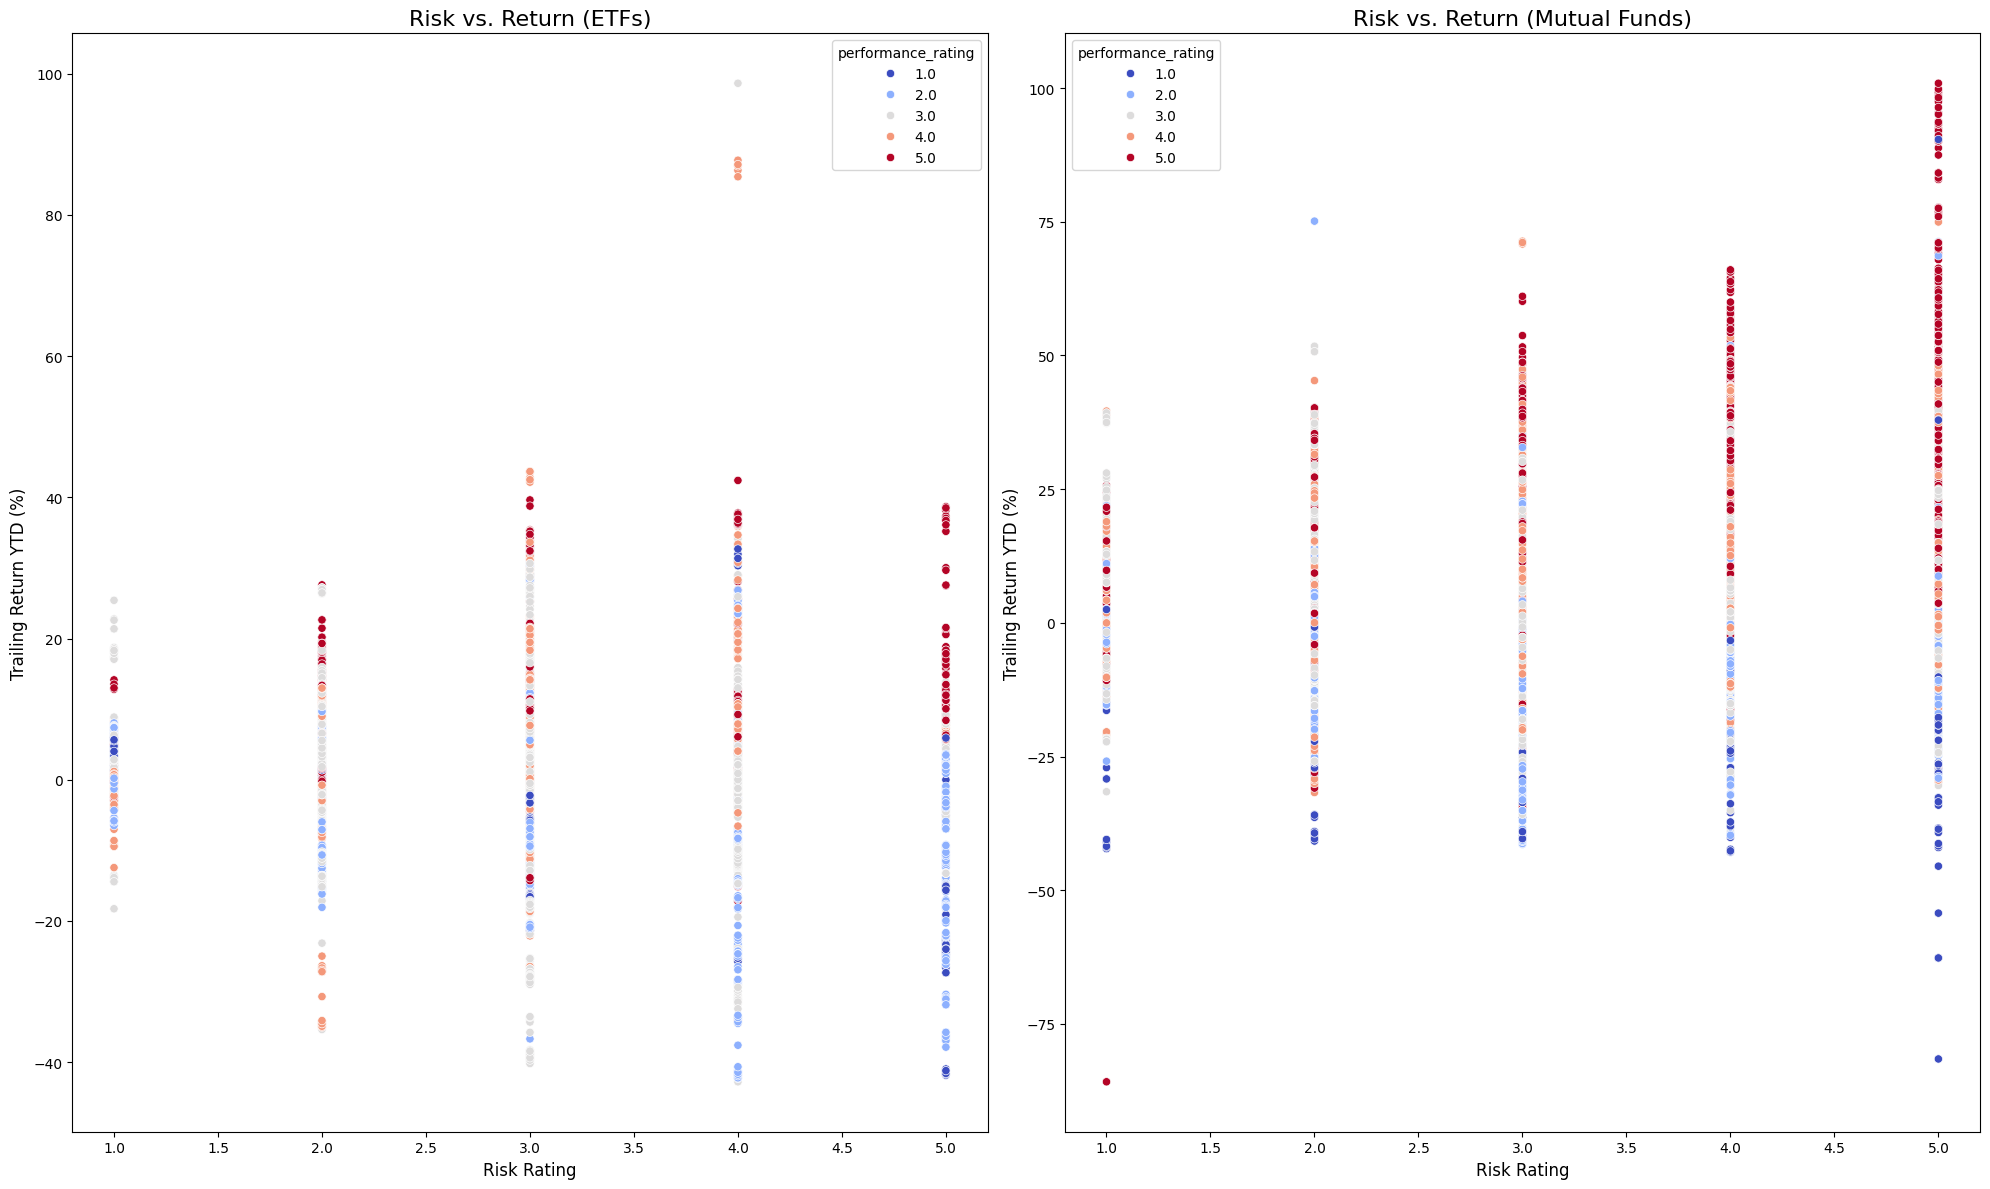

In [130]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))

# ETF Data Plot
sns.scatterplot(data=etf_data, x='risk_rating', y='fund_trailing_return_ytd', 
                hue='performance_rating', palette='coolwarm', ax=ax[0])
ax[0].set_title('Risk vs. Return (ETFs)', fontsize=16)
ax[0].set_xlabel('Risk Rating', fontsize=12)
ax[0].set_ylabel('Trailing Return YTD (%)', fontsize=12)

# Mutual Fund Data Plot
sns.scatterplot(data=mf_data, x='risk_rating', y='fund_trailing_return_ytd', 
                hue='performance_rating', palette='coolwarm', ax=ax[1])
ax[1].set_title('Risk vs. Return (Mutual Funds)', fontsize=16)
ax[1].set_xlabel('Risk Rating', fontsize=12)
ax[1].set_ylabel('Trailing Return YTD (%)', fontsize=12)

plt.tight_layout()
plt.show()


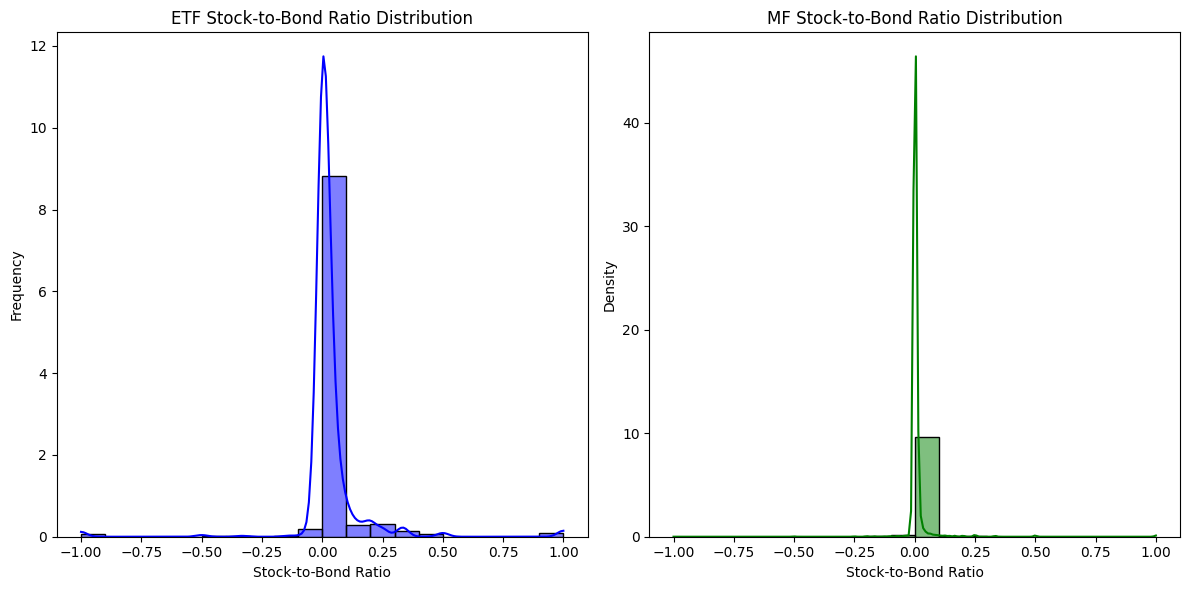

In [7]:
etf_data['bond_others'] = etf_data['asset_bond'] + etf_data['asset_cash'] + etf_data['asset_other']
mf_data['bond_others'] = mf_data['asset_bond'] + mf_data['asset_cash'] + mf_data['asset_other']


# Calculate stock-to-bond ratio for ETF data
etf_data['stock_bond_ratio'] = np.where(
    etf_data['bond_others'] == 0, np.nan, etf_data['asset_stock'] / etf_data['bond_others']
)
etf_data['stock_bond_ratio'] = etf_data['stock_bond_ratio'] / etf_data['stock_bond_ratio'].max()

# Calculate stock-to-bond ratio for MF data
mf_data['stock_bond_ratio'] = np.where(
    mf_data['bond_others'] == 0, np.nan, mf_data['asset_stock'] / mf_data['bond_others']
)
mf_data['stock_bond_ratio'] = mf_data['stock_bond_ratio'] / mf_data['stock_bond_ratio'].max()

# Plotting both distributions as subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ETF data plot
sns.histplot(etf_data['stock_bond_ratio'], bins=20, kde=True, stat="density", ax=axes[0], color='blue')
axes[0].set_title('ETF Stock-to-Bond Ratio Distribution')
axes[0].set_xlabel('Stock-to-Bond Ratio')
axes[0].set_ylabel('Frequency')

# MF data plot
sns.histplot(mf_data['stock_bond_ratio'], bins=20, kde=True, stat="density", ax=axes[1], color='green')
axes[1].set_title('MF Stock-to-Bond Ratio Distribution')
axes[1].set_xlabel('Stock-to-Bond Ratio')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
# Select relevant columns
columns_of_interest = ['fund_trailing_return_ytd', 'management_fees', 'fund_size',
                       'fund_return_2019', 'fund_return_2018', 'fund_return_2017']

# Drop rows with missing values in relevant columns
mutual_funds_clean = mf_data[columns_of_interest].dropna()
etfs_clean = etf_data[columns_of_interest].dropna()

# Standardize data
scaler = StandardScaler()
mutual_funds_scaled = scaler.fit_transform(mutual_funds_clean)
etfs_scaled = scaler.fit_transform(etfs_clean)


from sklearn.ensemble import IsolationForest

# Fit Isolation Forest for mutual funds
mutual_forest = IsolationForest(contamination=0.005, random_state=42)
mutual_funds_anomalies = mutual_forest.fit_predict(mutual_funds_scaled)

# Add anomaly column
mutual_funds_clean['Anomaly'] = mutual_funds_anomalies

# Fit Isolation Forest for ETFs
etfs_forest = IsolationForest(contamination=0.005, random_state=42)
etfs_anomalies = etfs_forest.fit_predict(etfs_scaled)

# Add anomaly column
etfs_clean['Anomaly'] = etfs_anomalies



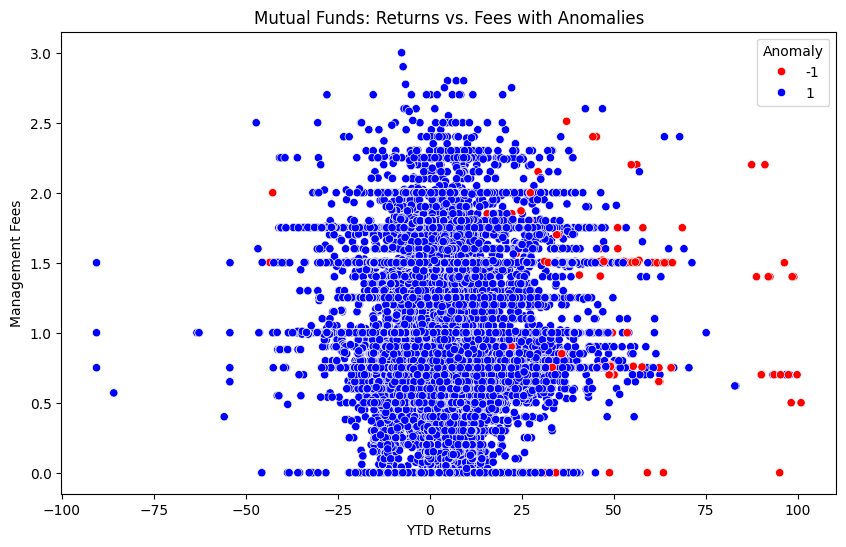

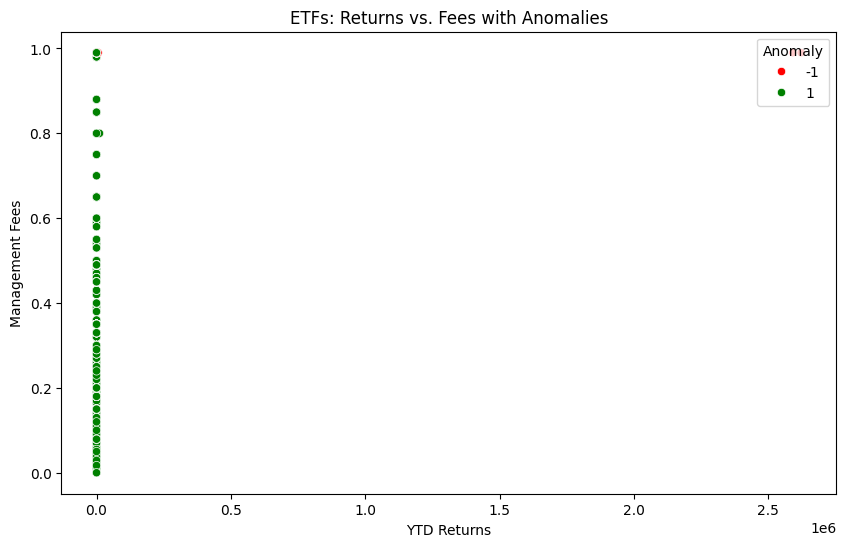

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot anomalies for mutual funds
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mutual_funds_clean, x='fund_trailing_return_ytd', y='management_fees', hue='Anomaly', palette={1: 'blue', -1: 'red'})
plt.title("Mutual Funds: Returns vs. Fees with Anomalies")
plt.xlabel("YTD Returns")
plt.ylabel("Management Fees")
plt.legend(title="Anomaly", loc="upper right")
plt.show()

# Plot anomalies for ETFs
plt.figure(figsize=(10, 6))
sns.scatterplot(data=etfs_clean, x='fund_trailing_return_ytd', y='management_fees', hue='Anomaly', palette={1: 'green', -1: 'red'})
plt.title("ETFs: Returns vs. Fees with Anomalies")
plt.xlabel("YTD Returns")
plt.ylabel("Management Fees")
plt.legend(title="Anomaly", loc="upper right")
plt.show()


In [10]:
# Display suspicious mutual fund rows
suspicious_mutual_funds = mutual_funds_clean[mutual_funds_clean['Anomaly'] == -1]
print(suspicious_mutual_funds[["fund_trailing_return_ytd", "management_fees"]].head(5))

# Display suspicious ETF rows
suspicious_etfs = etfs_clean[etfs_clean['Anomaly'] == -1]
print(suspicious_etfs[["fund_trailing_return_ytd", "management_fees"]].head(5))


     fund_trailing_return_ytd  management_fees
43                      45.50              1.5
53                      92.43              1.4
72                      93.68              0.7
404                     93.76              0.7
420                     92.00              1.4
      fund_trailing_return_ytd  management_fees
576                     -92.83             0.98
590                     -58.63             0.98
737                     -92.59             0.98
738                     -58.67             0.98
1093                    -92.83             0.98


In [68]:
strategies.sum(axis=0)

array([1990, 2869, 2389, 6290, 2455, 4009, 2576, 5989, 2007, 2203, 3767,
       2400, 2918, 2801, 3040, 2781, 3566, 2111, 3147, 5210, 3349, 5097,
       2272, 2579, 2208])

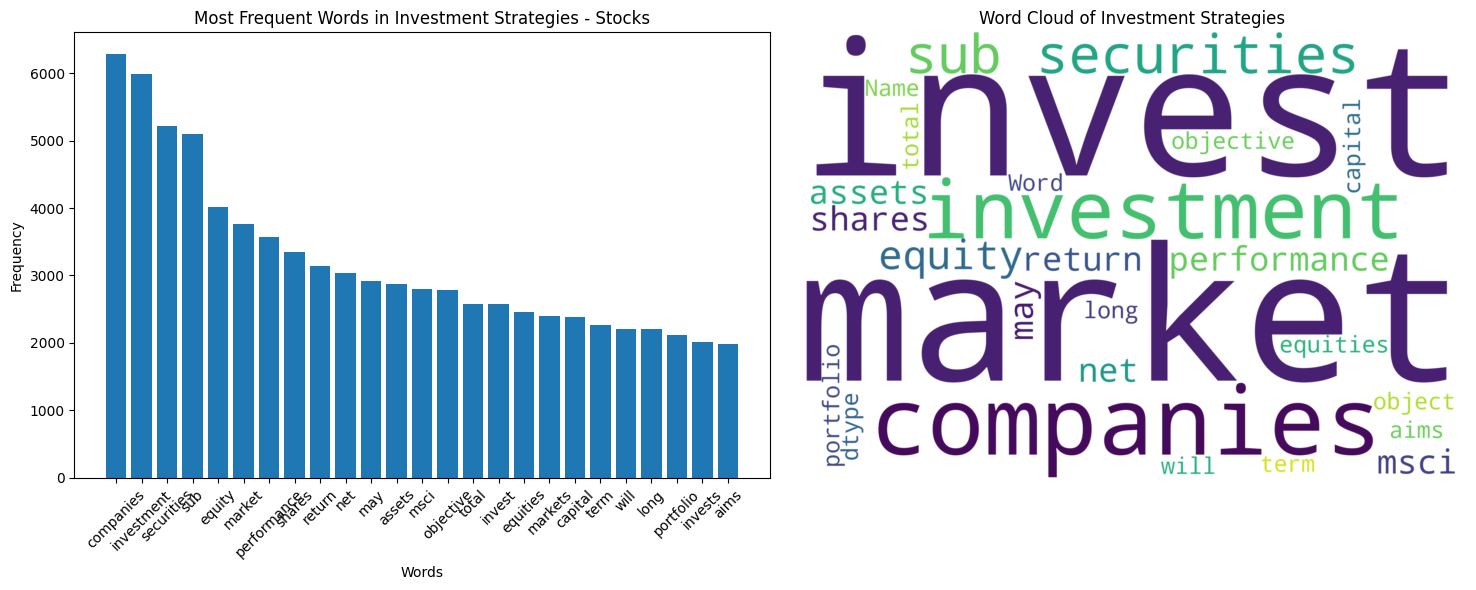

In [69]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.feature_extraction.text')

# Extracting top keywords from investment strategies using text analysis
from sklearn.feature_extraction.text import CountVectorizer
stopwords = (['fund'] + ['index'] + list(STOPWORDS))
vectorizer = CountVectorizer(stop_words=stopwords, max_features=25)
strategies = vectorizer.fit_transform((etf_data[etf_data['asset_stock'] >= 75]['investment_strategy']+mf_data[mf_data['asset_stock'] >= 75]['investment_strategy']).dropna())

# Visualizing the most frequent words
word_counts = pd.DataFrame({'Word': vectorizer.get_feature_names_out(), 'Count': strategies.sum(axis=0).A1})
word_counts = word_counts.sort_values(by= 'Count', ascending = False)
# Plotting both bar chart and word cloud side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
axs[0].bar(word_counts['Word'], word_counts['Count'])
axs[0].set_title('Most Frequent Words in Investment Strategies - Stocks')
axs[0].set_xlabel('Words')
axs[0].set_ylabel('Frequency')
axs[0].tick_params(axis='x', rotation=45)

# Word cloud
wordcloud = topicWordCloud(word_counts['Word'])
axs[1].imshow(wordcloud, interpolation='bilinear')
axs[1].set_title('Word Cloud of Investment Strategies')
axs[1].axis('off')

# Display the plot
plt.tight_layout()
plt.show()

In [473]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define target variable: Funds with YTD returns above the median
mutual_funds_df['high_performer'] = (mutual_funds_df['fund_trailing_return_ytd'] > mutual_funds_df['fund_trailing_return_ytd'].median()).astype(int)
etfs_df['high_performer'] = (etfs_df['fund_trailing_return_ytd'] > etfs_df['fund_trailing_return_ytd'].median()).astype(int)

# Features and target for mutual funds
mutual_features = ['management_fees', 'fund_size', 'sector_technology', 'sector_financial_services', 'sector_healthcare']
mutual_X = mutual_funds_df[mutual_features].fillna(0)
mutual_y = mutual_funds_df['high_performer']

# Features and target for ETFs
etfs_features = ['management_fees', 'fund_size', 'sector_technology', 'sector_financial_services', 'sector_healthcare']
etfs_X = etfs_df[etfs_features].fillna(0)
etfs_y = etfs_df['high_performer']

# Train-Test Split
mutual_X_train, mutual_X_test, mutual_y_train, mutual_y_test = train_test_split(mutual_X, mutual_y, test_size=0.3, random_state=42)
etfs_X_train, etfs_X_test, etfs_y_train, etfs_y_test = train_test_split(etfs_X, etfs_y, test_size=0.3, random_state=42)

# Random Forest Model for Mutual Funds
mutual_rf = RandomForestClassifier(random_state=42)
mutual_rf.fit(mutual_X_train, mutual_y_train)
mutual_preds = mutual_rf.predict(mutual_X_test)

# Random Forest Model for ETFs
etfs_rf = RandomForestClassifier(random_state=42)
etfs_rf.fit(etfs_X_train, etfs_y_train)
etfs_preds = etfs_rf.predict(etfs_X_test)

# Evaluation
print("Mutual Funds Performance:")
print(classification_report(mutual_y_test, mutual_preds))

print("ETFs Performance:")
print(classification_report(etfs_y_test, etfs_preds))



Mutual Funds Performance:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      8925
           1       0.84      0.82      0.83      8356

    accuracy                           0.84     17281
   macro avg       0.84      0.84      0.84     17281
weighted avg       0.84      0.84      0.84     17281

ETFs Performance:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1478
           1       0.93      0.92      0.92      1371

    accuracy                           0.92      2849
   macro avg       0.92      0.92      0.92      2849
weighted avg       0.92      0.92      0.92      2849



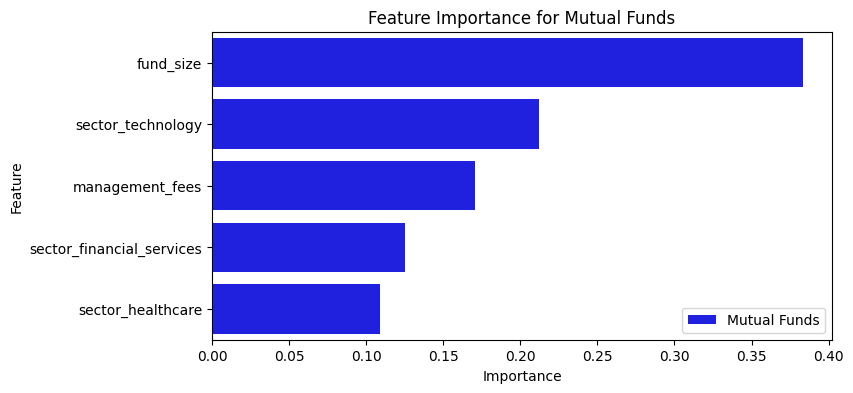

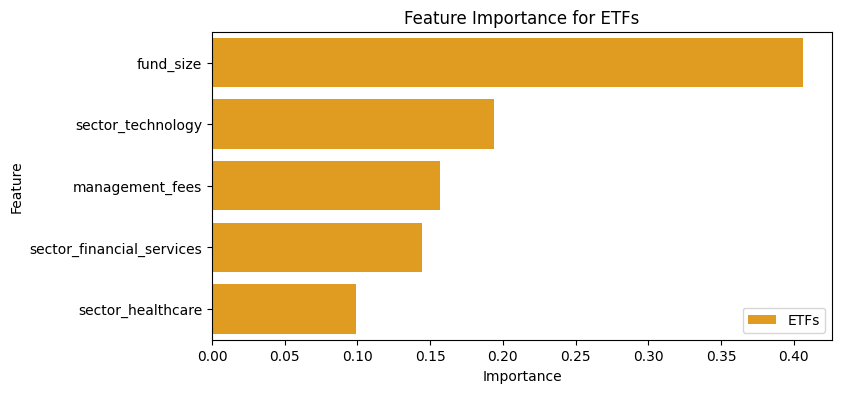

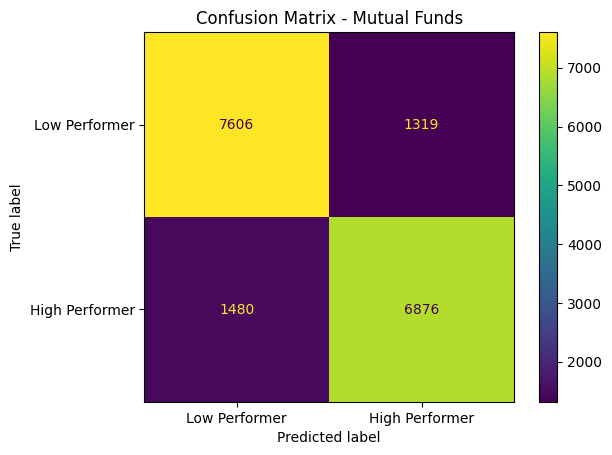

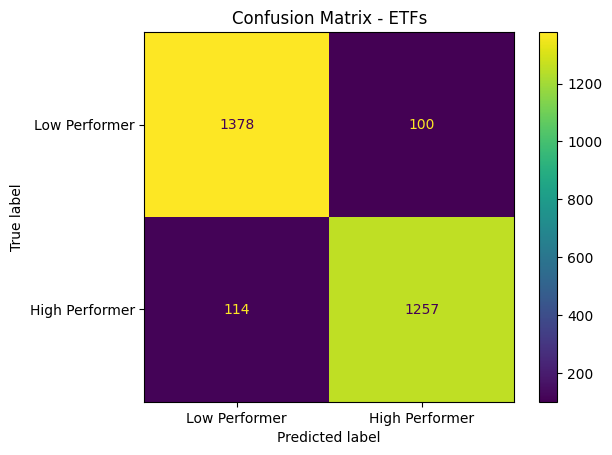

In [480]:
# Feature importance for mutual funds
mutual_importances = pd.DataFrame({
    'Feature': mutual_features,
    'Importance': mutual_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Feature importance for ETFs
etfs_importances = pd.DataFrame({
    'Feature': etfs_features,
    'Importance': etfs_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 4))
sns.barplot(data=mutual_importances, x='Importance', y='Feature', color='blue', label='Mutual Funds')
plt.title("Feature Importance for Mutual Funds")
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=etfs_importances, x='Importance', y='Feature', color='orange', label='ETFs')
plt.title("Feature Importance for ETFs")
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix for Mutual Funds
ConfusionMatrixDisplay.from_estimator(mutual_rf, mutual_X_test, mutual_y_test, display_labels=["Low Performer", "High Performer"])
plt.title("Confusion Matrix - Mutual Funds")
plt.show()

# Confusion Matrix for ETFs
ConfusionMatrixDisplay.from_estimator(etfs_rf, etfs_X_test, etfs_y_test, display_labels=["Low Performer", "High Performer"])
plt.title("Confusion Matrix - ETFs")
plt.show()



# Return Prediction: Predict future ETF returns using machine learning.

In [111]:
# Drop columns with more than 90% missing values
threshold = 0.9
columns_to_drop = etf_data.columns[etf_data.isnull().mean() > threshold]
cleaned_data = etf_data.drop(columns=columns_to_drop)

# Impute missing values
numerical_columns = cleaned_data.select_dtypes(include=['float64', 'int64']).columns
cleaned_data[numerical_columns] = cleaned_data[numerical_columns].fillna(cleaned_data[numerical_columns].median())

categorical_columns = cleaned_data.select_dtypes(include=['object']).columns
cleaned_data[categorical_columns] = cleaned_data[categorical_columns].fillna(cleaned_data[categorical_columns].mode().iloc[0])

# Verify missing values are handled
assert cleaned_data.isnull().sum().sum() == 0, "Missing values remain after cleaning."

In [112]:
###  Return Prediction
# Select features and target for prediction
feature_columns = [col for col in cleaned_data.columns if 'fund_return_201' in col and 'q1' not in col]
target_column = 'fund_return_2020_q1'

# Filter data for rows with available target values
prediction_data = cleaned_data.dropna(subset=[target_column])

X = prediction_data[feature_columns]
y = prediction_data[target_column]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 95.33010931786157
R-squared: 0.8808602572908819


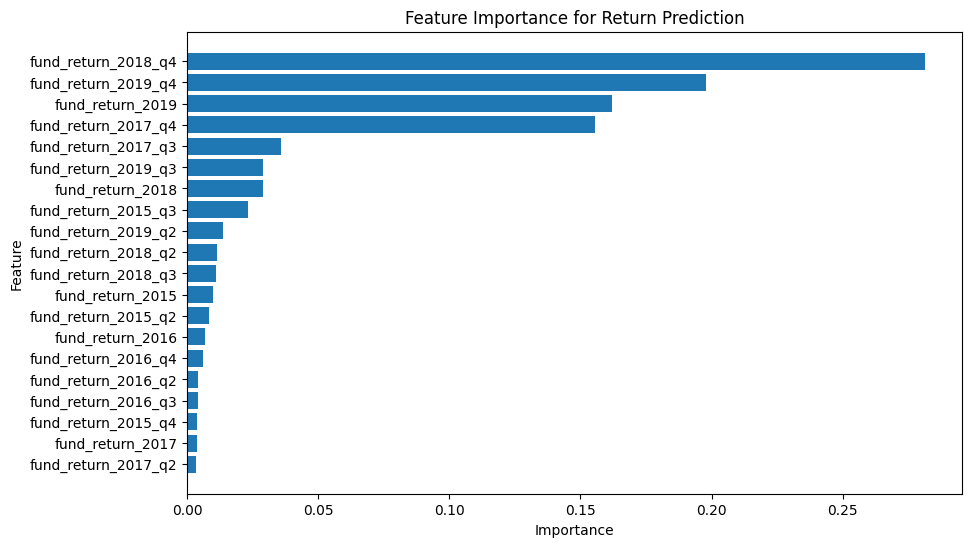

In [113]:
### Feature Importance
# Analyze feature importance
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Return Prediction')
plt.gca().invert_yaxis()
plt.show()

# Risk Analysis: Analyze the risk profiles of ETFs based on performance and risk ratings.

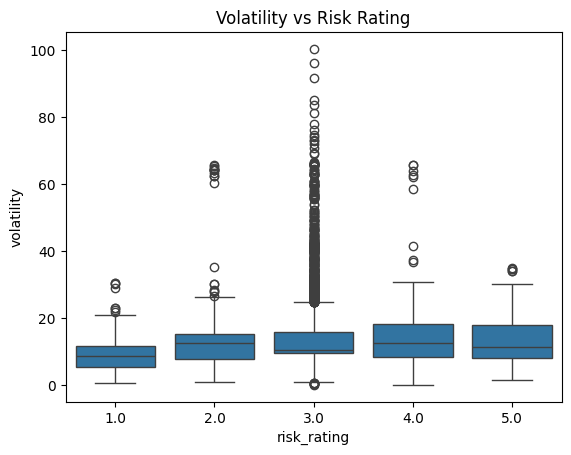

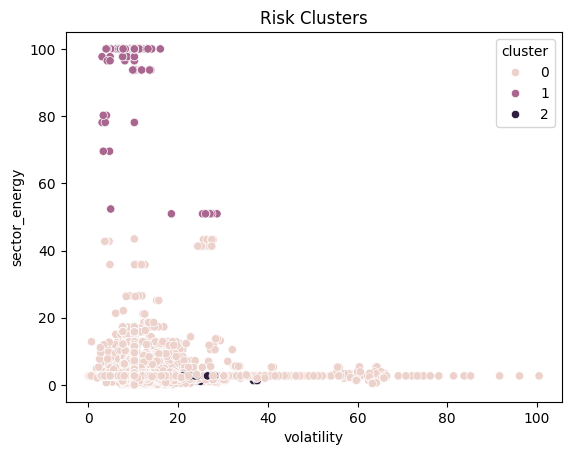

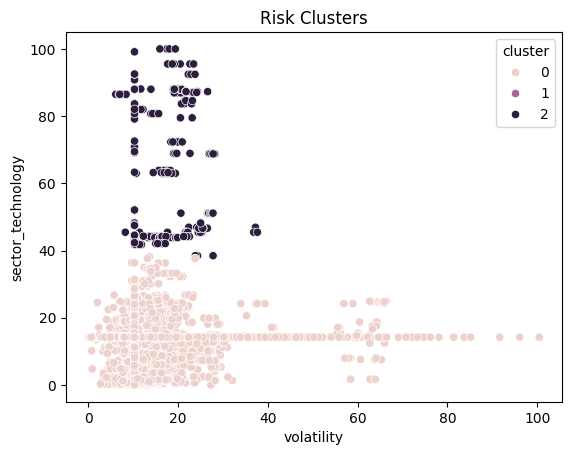

In [123]:
# Select relevant columns for risk analysis
risk_data = cleaned_data[['risk_rating', 'fund_return_2019', 'fund_return_2018', 'sector_energy', 'sector_technology']]

# Calculate volatility as a tool to analyze risk
historical_returns = cleaned_data[['fund_return_2019', 'fund_return_2018', 'fund_return_2017']]
risk_data['volatility'] = historical_returns.std(axis=1)

# Visualize risk ratings and their correlations
sns.boxplot(x='risk_rating', y='volatility', data=risk_data)
plt.title('Volatility vs Risk Rating')
plt.show()

# Cluster ETFs by risk
from sklearn.cluster import KMeans
scaler = StandardScaler()
risk_features = scaler.fit_transform(risk_data[['volatility', 'sector_energy', 'sector_technology']])
kmeans = KMeans(n_clusters=3, random_state=42)
risk_data['cluster'] = kmeans.fit_predict(risk_features)

# Visualize Clusters
sns.scatterplot(x=risk_data['volatility'], y=risk_data['sector_energy'], hue=risk_data['cluster'])
plt.title('Risk Clusters')
plt.show()
sns.scatterplot(x=risk_data['volatility'], y=risk_data['sector_technology'], hue=risk_data['cluster'])
plt.title('Risk Clusters')
plt.show()
